# LabLivre


Relatório detalhado de tratamento de dados. Para análises acessíveis ver a parte de visualizações.

Observação: IA (Cursor) foi usado para a produção deste relatório, principalmente para agilizar a produção de gráficos.


In [420]:
import json
import time
import requests
import glob
import sqlite3
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# cores do lablivre
palette = ["#412355", "#F2701C", "#18CEE6"]

## 1. Extração dos dados


In [421]:
# script de coleta de dados foi executado separadamente


def get_data(page: int) -> dict:
    url = "https://api.obrasgov.gestao.gov.br/obrasgov/api/projeto-investimento"
    params = {"uf": "DF", "pagina": page, "tamanhoDaPagina": 100}
    headers = {"accept": "*/*"}

    response = requests.get(url, params=params, headers=headers)

    if response.status_code != 200:
        raise Exception(f"Failed to get data: {response.status_code}")

    return response.json()


def main():
    # inelegante mas eficiente. certamente não tem 10000 itens
    for page in range(100):
        response = get_data(page)
        print(f"Page {page} processed")

        # salvar dados brutos primeiro para não depender da api caso ocorram problemas
        with open(f"data/data-{page}.json", "w", encoding="utf-8") as f:
            json.dump(response["content"], f, indent=4)
        print(f"Data saved to data/data-{page}.json")

        time.sleep(1)

        page += 1


# if __name__ == "__main__":
#     main()

## 2. Tratamento de dados


In [422]:
import pandas as pd
import glob


def load_json_files() -> list[dict]:
    json_files = glob.glob("data/data-*.json")
    all_records = []

    for file in json_files:
        with open(file, "r") as f:
            records = json.load(f)
            all_records.extend(records)

    return all_records


df = pd.DataFrame(load_json_files())

df.info(memory_usage="deep")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 834 entries, 0 to 833
Data columns (total 31 columns):
 #   Column                              Non-Null Count  Dtype 
---  ------                              --------------  ----- 
 0   idUnico                             834 non-null    object
 1   nome                                834 non-null    object
 2   cep                                 400 non-null    object
 3   endereco                            430 non-null    object
 4   descricao                           834 non-null    object
 5   funcaoSocial                        834 non-null    object
 6   metaGlobal                          834 non-null    object
 7   dataInicialPrevista                 832 non-null    object
 8   dataFinalPrevista                   832 non-null    object
 9   dataInicialEfetiva                  23 non-null     object
 10  dataFinalEfetiva                    7 non-null      object
 11  dataCadastro                        834 non-null    object

In [423]:
nested_cols = [
    "tomadores",
    "executores",
    "repassadores",
    "eixos",
    "tipos",
    "subTipos",
    "fontesDeRecurso",
]

### 2.1 Duplicatas


In [424]:
from analyse_duplicates import check_duplicates, analyze_false_duplicates

# existem duplicatas que só diferem no conteúdo das listas. não quero entediar você com esse código gerado por IA então movi para outro arquivo

check_duplicates(df)
analyze_false_duplicates(df, "results/duplicate_records_report")

Columns with lists: ['tomadores', 'executores', 'repassadores', 'eixos', 'tipos', 'subTipos', 'fontesDeRecurso']
Number of duplicate rows (not considering list columns): 122
Number of duplicate rows: 87
Number of 'false duplicate' rows: 70
Unique idUnico values in false duplicates: 35
Report written to duplicate_records_report.txt


In [425]:
# após investigação detalhada, todas as 'falsas duplicatas' se parecem com isso:

# Linha 133: [{'id': 90, 'descricao': 'Preservação do Patrimônio', 'idTipo': 5}] (5 = Administrativo)
# Linha 491: [{'id': 90, 'descricao': 'Preservação do Patrimônio', 'idTipo': 43}] (43 = Cultura)

# para mais exemplos, consulte o relatório (`results/duplicate_records_report.txt`).
# não tenho certeza do motivo disso; talvez os rótulos sejam ambíguos para as pessoas que preenchem algum formulário.
# mas isso parece indicar que são, de fato, duplicatas. então serão removidas.

df.duplicated(subset=["idUnico"]).sum()
df.drop_duplicates(subset=["idUnico"], inplace=True)

In [426]:
pd.set_option("display.max_columns", None)
df.head()

,idUnico,nome,cep,endereco,descricao,funcaoSocial,metaGlobal,dataInicialPrevista,dataFinalPrevista,dataInicialEfetiva,dataFinalEfetiva,dataCadastro,especie,natureza,naturezaOutras,situacao,descPlanoNacionalPoliticaVinculado,uf,qdtEmpregosGerados,descPopulacaoBeneficiada,populacaoBeneficiada,observacoesPertinentes,isModeladaPorBim,dataSituacao,tomadores,executores,repassadores,eixos,tipos,subTipos,fontesDeRecurso
0,1828.53-16,SISEG - Sistema integrado de segurança,1,,implantação dos sistemas de monitoramento por ...,implantação dos sistemas de monitoramento por ...,Modernização do sistema de segurança do Banco ...,2019-02-04,2024-02-06,None,None,2021-05-12,Recuperação,Projeto,,Cadastrada,None,DF,None,None,None,None,None,2021-05-12,[],"[{'nome': 'BANCO CENTRAL DO BRASIL', 'codigo':...",[],"[{'id': 1, 'descricao': 'Administrativo'}]","[{'id': 5, 'descricao': 'Administrativo', 'idE...","[{'id': 59, 'descricao': 'Obras em Imóveis de ...","[{'origem': 'Federal', 'valorInvestimentoPrevi..."
1,1711.53-18,Reforma do espelho d'água do Edifício-Sede do ...,1,,Reforma do espelho d'água do Edifício-Sede do ...,Reestabelecer a impermeabilização do espelho d...,Recuperação do sistema de impermeabilização e ...,2021-01-04,2021-05-18,None,None,2021-05-04,Reforma,Obra,,Cadastrada,None,DF,None,None,None,None,None,2021-05-04,"[{'nome': 'BANCO CENTRAL DO BRASIL', 'codigo':...","[{'nome': 'BANCO CENTRAL DO BRASIL', 'codigo':...",[],"[{'id': 1, 'descricao': 'Administrativo'}]","[{'id': 5, 'descricao': 'Administrativo', 'idE...","[{'id': 59, 'descricao': 'Obras em Imóveis de ...","[{'origem': 'Federal', 'valorInvestimentoPrevi..."
2,1989.53-01,Elaboração de projetos arquitetônicos e de eng...,1,"Campus Universitário Darcy Ribeiro, Brasília - DF",Contratação de empresa especializada para elab...,Obras para unidades acadêmicas de ensino e pes...,Elaboração de projetos de engenharia e Arquite...,2021-05-18,2021-09-29,None,None,2021-05-17,Construção,Projeto,None,Cadastrada,None,DF,None,None,None,None,None,2021-05-17,[],"[{'nome': 'FUNDACAO UNIVERSIDADE DE BRASILIA',...","[{'nome': 'FUNDACAO UNIVERSIDADE DE BRASILIA',...","[{'id': 1, 'descricao': 'Administrativo'}]","[{'id': 8, 'descricao': 'Educação', 'idEixo': 1}]","[{'id': 46, 'descricao': 'Instituições Federai...","[{'origem': 'Federal', 'valorInvestimentoPrevi..."
3,2004.53-58,SISEG - Sistema integrado de segurança,1,,implantação dos sistemas de monitoramento por ...,implantação dos sistemas de monitoramento por ...,Modernização do sistema de segurança do Banco ...,2019-02-04,2024-02-06,None,None,2021-05-18,Recuperação,Projeto,,Cadastrada,None,DF,None,None,None,None,None,2021-05-18,[{'nome': 'BANCO CENTRAL DO BRASIL-ORC.FISCAL/...,"[{'nome': 'BANCO CENTRAL DO BRASIL', 'codigo':...",[],"[{'id': 1, 'descricao': 'Administrativo'}]","[{'id': 5, 'descricao': 'Administrativo', 'idE...","[{'id': 59, 'descricao': 'Obras em Imóveis de ...","[{'origem': 'Federal', 'valorInvestimentoPrevi..."
4,2617.53-02,CENTRO DE FORMAÇÃO TECNOLOGICA - CFT - CAMPUS ...,1,"Área Especial n° 01, Quadra 16, Cidade do Auto...","construção um galpão com pé direito alto, que ...",atender a comunidade acadêmica do Campus Estru...,aumentar a oferta de cursos técnicos/tecnológi...,2020-12-01,2021-10-27,None,None,2021-06-18,Construção,Obra,,Cadastrada,triplicar as matrículas da educação profission...,DF,None,None,None,None,None,2021-06-18,[{'nome': 'INSTITUTO FED. ED. CIENCIA E TEC. D...,[{'nome': 'INSTITUTO FED. ED. CIENCIA E TEC. D...,"[{'nome': 'MINISTÉRIO DA EDUCAÇÃO', 'codigo': ...","[{'id': 4, 'descricao': 'Social'}]","[{'id': 46, 'descricao': 'Educação', 'idEixo':...","[{'id': 84, 'descricao': 'Educação', 'idTipo':...","[{'origem': 'Federal', 'valorInvestimentoPrevi..."


### 2.2 Valores ausentes


In [427]:
# remover ceps preenchidos com 1 ou espaço.
df["cep"] = df["cep"].str.replace(r"^1$", "", regex=True)
df["cep"] = df["cep"].str.replace(r"\s+", "", regex=True).replace("", None)
df["cep"] = df["cep"].str.replace("-", "")
df["cep"] = df["cep"].str.replace(".", "")
df["cep"].nunique()

94

In [428]:
# remover enderecos preenchidos com 1 ou espaço.
df["endereco"] = df["endereco"].str.strip()
df["endereco"] = df["endereco"].str.replace(r"^1$", "", regex=True)
df["endereco"] = df["endereco"].str.replace(r"^\s+$", "", regex=True).replace("", None)
df["endereco"].nunique()

238

In [429]:
# object_cols = df.drop(columns=nested_cols, axis=1)
info_df = pd.DataFrame(
    {
        "Unique Values": object_cols.nunique(),
        "% Unique": (object_cols.nunique() / object_cols.count() * 100).round(1),
        "NaN Values": object_cols.isna().sum(),
        "% NaN": (object_cols.isna().sum() / len(object_cols) * 100).round(1),
    }
)
info_df[info_df["% NaN"] > 1].sort_values(by="% NaN", ascending=False)

,Unique Values,% Unique,NaN Values,% NaN
dataFinalEfetiva,5,100.0,707,99.3
dataInicialEfetiva,13,59.1,690,96.9
observacoesPertinentes,4,3.8,606,85.1
qdtEmpregosGerados,21,15.2,574,80.6
populacaoBeneficiada,30,21.4,572,80.3
descPopulacaoBeneficiada,42,29.2,568,79.8
naturezaOutras,38,20.0,522,73.3
cep,94,39.7,475,66.7
descPlanoNacionalPoliticaVinculado,78,31.5,464,65.2
endereco,245,65.3,337,47.3


Há muitos valores ausentes. Não entendo o motivo disso, mas não me parece um erro. Muitos desses são datas que suspeito serem futuras, ou campos do tipo 'outras observações'. Mais notável é a ausência de `qdtEmpregosGerados`, `populacaoBeneficiada`, `cep` e `endereco`. Não tiraria conclusões precipitadas sem saber mais.

Também não vejo necessidade de fazer imputação aqui. Então todos permanecem como estão.


### 2.3 Tipagem


In [430]:
# usar isso em cada coluna para verificar o tipo da variável
df["isModeladaPorBim"].value_counts(dropna=False)

isModeladaPorBim
False    471
None     216
True      25
Name: count, dtype: int64

In [431]:
df["isModeladaPorBim"] = df["isModeladaPorBim"].astype("boolean")

In [432]:
# variaveis categoricas
df["natureza"] = df["natureza"].astype("category")
df["situacao"] = df["situacao"].astype("category")
df["especie"] = df["especie"].astype("category")
df["uf"] = df["uf"].astype("category")

In [433]:
# variaveis de data
# verifiquei manualmente os registros para erros de formatação mas não encontrei problemas

date_cols = [
    "dataInicialPrevista",
    "dataFinalPrevista",
    "dataInicialEfetiva",
    "dataFinalEfetiva",
    "dataCadastro",
    "dataSituacao",
]

for col in date_cols:
    df[col] = pd.to_datetime(df[col], errors="coerce")

In [434]:
# alguns registros tem strings em vez de ints. esses registros também têm outros problemas; veja abaixo.
# isso coage strings para null
# converte para float em vez de int para permitir valores nulos
df["qdtEmpregosGerados"] = pd.to_numeric(df["qdtEmpregosGerados"], errors="coerce")
df["populacaoBeneficiada"] = pd.to_numeric(df["populacaoBeneficiada"], errors="coerce")

In [435]:
df.info(memory_usage="deep")

<class 'pandas.core.frame.DataFrame'>
Index: 712 entries, 0 to 832
Data columns (total 31 columns):
 #   Column                              Non-Null Count  Dtype         
---  ------                              --------------  -----         
 0   idUnico                             712 non-null    object        
 1   nome                                712 non-null    object        
 2   cep                                 237 non-null    object        
 3   endereco                            312 non-null    object        
 4   descricao                           712 non-null    object        
 5   funcaoSocial                        712 non-null    object        
 6   metaGlobal                          712 non-null    object        
 7   dataInicialPrevista                 710 non-null    datetime64[ns]
 8   dataFinalPrevista                   710 non-null    datetime64[ns]
 9   dataInicialEfetiva                  22 non-null     datetime64[ns]
 10  dataFinalEfetiva               

### 2.4 Colunas aninhadas


In [436]:
def normalize_nested_column(
    df: pd.DataFrame, id_col: str, nested_col: str
) -> pd.DataFrame:
    def convert_dict_values_to_str(x):
        # pd.json_normalize(df['tomadores'].explode()) converte o id para float, o que pode causar problemas devido à imprecisão de ponto flutuante mesmo se convertido de volta para int/str. por isso, preciso converter os valores para strings primeiro, o que requer um código um pouco confuso:

        if not isinstance(x, list):
            return x
        return [{key: str(value) for key, value in item.items()} for item in x]

    df[nested_col] = df[nested_col].apply(convert_dict_values_to_str)
    exploded = df[[id_col, nested_col]].explode(nested_col)
    exploded = exploded.dropna(subset=[nested_col])
    normalized = pd.json_normalize(exploded[nested_col])
    normalized[id_col] = exploded[id_col].values
    return normalized


def create_entity_table_from_junction_table(
    old_df: pd.DataFrame, prev_index: str, actual_index: str
) -> pd.DataFrame:
    new_df = old_df.dropna(subset=[prev_index])
    new_df.drop_duplicates(subset=[actual_index], inplace=True)
    new_df.set_index(actual_index, inplace=True)
    new_df.drop(prev_index, axis=1, inplace=True)
    return new_df

In [437]:
# reuni essas tabelas em uma só, pois são todas referentes a instituicoes e usam o mesmo sistema de códigos.

projeto_tomadores_df = normalize_nested_column(df, "idUnico", "tomadores")
projeto_executores_df = normalize_nested_column(df, "idUnico", "executores")
projeto_repassadores_df = normalize_nested_column(df, "idUnico", "repassadores")

tomadores_df = create_entity_table_from_junction_table(
    projeto_tomadores_df, "idUnico", "codigo"
)
executores_df = create_entity_table_from_junction_table(
    projeto_executores_df, "idUnico", "codigo"
)
repassadores_df = create_entity_table_from_junction_table(
    projeto_repassadores_df, "idUnico", "codigo"
)

instituicoes_df = pd.concat([tomadores_df, executores_df, repassadores_df])

# deduplicate indices
instituicoes_df = instituicoes_df.loc[~instituicoes_df.index.duplicated(keep="first")]

instituicoes_df.head(1)

,nome
codigo,
25280,BANCO CENTRAL DO BRASIL


In [438]:
projeto_eixos_df = normalize_nested_column(df, "idUnico", "eixos")

eixos_df = create_entity_table_from_junction_table(projeto_eixos_df, "idUnico", "id")

eixos_df.head(1)

,descricao
id,
1,Administrativo


In [439]:
projeto_tipos_df = normalize_nested_column(df, "idUnico", "tipos")

tipos_df = create_entity_table_from_junction_table(projeto_tipos_df, "idUnico", "id")

tipos_df.head(1)

,descricao,idEixo
id,,
5,Administrativo,1


In [440]:
projeto_subtipos_df = normalize_nested_column(df, "idUnico", "subTipos")

subtipos_df = create_entity_table_from_junction_table(
    projeto_subtipos_df, "idUnico", "id"
)

subtipos_df.head(1)

,descricao,idTipo
id,,
59,Obras em Imóveis de Uso Público,5


In [441]:
# nesse caso é one to many e nao many to many, entao nao precisa da tabela intermediaria. mas reutiliza o codigo de qualquer forma

fontes_de_recurso_df = normalize_nested_column(
    df, "idUnico", "fontesDeRecurso"
).reset_index(drop=True)

# nesse caso estava certo o float
fontes_de_recurso_df["valorInvestimentoPrevisto"] = pd.to_numeric(
    fontes_de_recurso_df["valorInvestimentoPrevisto"], errors="coerce"
)

fontes_de_recurso_df.head(1)

,origem,valorInvestimentoPrevisto,idUnico
0,Federal,23427554.88,1828.53-16


In [442]:
df.drop(columns=nested_cols, inplace=True)

### 2.5 Carregamento de dados


In [443]:
import sqlite3

with sqlite3.connect("projeto_investimento.db") as con:
    # main
    df.to_sql("projeto_investimento", con, if_exists="replace")

    ## todo
    #   manter tipagem
    # fazer tabelas direito

    # entity tables
    instituicoes_df.to_sql("instituicoes", con, if_exists="replace")
    eixos_df.to_sql("eixos", con, if_exists="replace")
    tipos_df.to_sql("tipos", con, if_exists="replace")
    subtipos_df.to_sql("subtipos", con, if_exists="replace")
    fontes_de_recurso_df.to_sql("fontes_de_recurso", con, if_exists="replace")

    # junction tables
    projeto_tomadores_df.to_sql("projeto_tomadores", con, if_exists="replace")
    projeto_executores_df.to_sql("projeto_executores", con, if_exists="replace")
    projeto_repassadores_df.to_sql("projeto_repassadores", con, if_exists="replace")
    projeto_eixos_df.to_sql("projeto_eixos", con, if_exists="replace")
    projeto_tipos_df.to_sql("projeto_tipos", con, if_exists="replace")
    projeto_subtipos_df.to_sql("projeto_subtipos", con, if_exists="replace")

In [444]:
# with sqlite3.connect("projeto_investimento.db") as con:
#     df = pd.read_sql_query("SELECT * FROM projeto_investimento", con)

## 3. Análise


### 3.1 Informações básicas

**Colunas:** 31 (24 após normalização)

-   **texto**
    - dados básicos: `idUnico`, `nome`, `descricao`, `funcaoSocial`, `metaGlobal`
    - geográficos: `cep`, `endereco`
    - descrições opcionais: `naturezaOutras`, `descPlanoNacionalPoliticaVinculado`, `descPopulacaoBeneficiada`, `observacoesPertinentes`
-   **numéricos**
    -   `qdtEmpregosGerados`
    -   `populacaoBeneficiada`
-   **datas**
    -   `dataInicialPrevista`, `dataFinalPrevista`, `dataInicialEfetiva`, `dataFinalEfetiva`, `dataCadastro`, `dataSituacao`
-   **categorias**
    -   `natureza` (Estudo, Obra, Outros, Projeto, Projeto de Investimento em Infraestrutura)
    -   `situacao` (Cadastrada, Cancelada, Concluída, Em execução, Inacabada, Inativada, Paralisada)
    -   `especie` (Ampliação, Construção, Fabricação, Máquinas e Equipamentos, Recuperação, Reforma)
    -   `uf` (DF)
    -   `isModeladaPorBim` (Sim, Não)

-   **colunas aninhadas** (removidas após normalização)
    -   `tomadores`, `executores`, `repassadores`, `eixos`, `tipos`, `subTipos`, `fontesDeRecurso`

**Entries:** 712 (após deduplicação de 834 registros originais)

**Valores ausentes mais significativos:**

-   `dataFinalEfetiva`: 707 nulos (99.3%)
-   `dataInicialEfetiva`: 690 nulos (96.9%)
-   `qdtEmpregosGerados`: 677 nulos (95.1%)
-   `populacaoBeneficiada`: 677 nulos (95.1%)
-   `endereco`: 337 nulos (47.3%)
-   `cep`: 365 nulos (51.3%)
-   `descPlanoNacionalPoliticaVinculado`: 464 nulos (65.2%)
-   `isModeladaPorBim`: 216 nulos (30.3%)

As colunas aninhadas foram normalizadas e separadas em tabelas relacionadas no banco de dados SQLite, incluindo tabelas de entidades (instituições, eixos, tipos, subtipos, fontes de recurso) e tabelas de junção (projeto_tomadores, projeto_executores, projeto_repassadores, projeto_eixos, projeto_tipos, projeto_subtipos).

Tomadores, executores e repassadores partilham do mesmo sistema de códigos e portanto estão armazenados na mesma tabela.

Eixos, tipos, subtipos poderiam ser armazenados na mesma tabela com perda de normalização mas ganho em simplicidade.


### 3.2 Qualidade


Em questão de anomalias, temos:

1.  duplicados que diferem apenas no subtipo, como:

```json
[
    {
        "id": 15,
        "descricao": "Aquisição de Máquinas e Equipamentos",
        "idTipo": 41
    },
    {
        "id": 15,
        "descricao": "Aquisição de Máquinas e Equipamentos",
        "idTipo": 14
    }
]
```

2.  organizacoes com mais de um codigo, como:

```json
[
    {
        "codigo": 26,
        "nome": "PRESIDÊNCIA DA REPÚBLICA"
    },
    {
        "codigo": 20000,
        "nome": "Presidencia da República"
    }
]
```

3.  125 registros similares com os mesmos erros (' ' em vez de int em `qdtEmpregosGerados` e `populacaoBeneficiada`, que também possuem muitos valores ausentes)

4.  CEPs preenchidos errado (`1`, ` `)

5.  Vários campos (`cep`, `endereco`, `qdtEmpregosGerados`) preenchidos com um espaço em branco, dando a impressão que tem menos nulos do que realmente tem.

Sem mais informações sobre o domínio, é dificil. Mas são algo a ser investigado. Falta validação no formulário, ou ele é confuso para os usuários.


### 3.3 Descritiva


In [445]:
df.head(5)

,idUnico,nome,cep,endereco,descricao,funcaoSocial,metaGlobal,dataInicialPrevista,dataFinalPrevista,dataInicialEfetiva,dataFinalEfetiva,dataCadastro,especie,natureza,naturezaOutras,situacao,descPlanoNacionalPoliticaVinculado,uf,qdtEmpregosGerados,descPopulacaoBeneficiada,populacaoBeneficiada,observacoesPertinentes,isModeladaPorBim,dataSituacao
0,1828.53-16,SISEG - Sistema integrado de segurança,None,None,implantação dos sistemas de monitoramento por ...,implantação dos sistemas de monitoramento por ...,Modernização do sistema de segurança do Banco ...,2019-02-04,2024-02-06,NaT,NaT,2021-05-12,Recuperação,Projeto,,Cadastrada,None,DF,NaN,None,NaN,None,<NA>,2021-05-12
1,1711.53-18,Reforma do espelho d'água do Edifício-Sede do ...,None,None,Reforma do espelho d'água do Edifício-Sede do ...,Reestabelecer a impermeabilização do espelho d...,Recuperação do sistema de impermeabilização e ...,2021-01-04,2021-05-18,NaT,NaT,2021-05-04,Reforma,Obra,,Cadastrada,None,DF,NaN,None,NaN,None,<NA>,2021-05-04
2,1989.53-01,Elaboração de projetos arquitetônicos e de eng...,None,"Campus Universitário Darcy Ribeiro, Brasília - DF",Contratação de empresa especializada para elab...,Obras para unidades acadêmicas de ensino e pes...,Elaboração de projetos de engenharia e Arquite...,2021-05-18,2021-09-29,NaT,NaT,2021-05-17,Construção,Projeto,None,Cadastrada,None,DF,NaN,None,NaN,None,<NA>,2021-05-17
3,2004.53-58,SISEG - Sistema integrado de segurança,None,None,implantação dos sistemas de monitoramento por ...,implantação dos sistemas de monitoramento por ...,Modernização do sistema de segurança do Banco ...,2019-02-04,2024-02-06,NaT,NaT,2021-05-18,Recuperação,Projeto,,Cadastrada,None,DF,NaN,None,NaN,None,<NA>,2021-05-18
4,2617.53-02,CENTRO DE FORMAÇÃO TECNOLOGICA - CFT - CAMPUS ...,None,"Área Especial n° 01, Quadra 16, Cidade do Auto...","construção um galpão com pé direito alto, que ...",atender a comunidade acadêmica do Campus Estru...,aumentar a oferta de cursos técnicos/tecnológi...,2020-12-01,2021-10-27,NaT,NaT,2021-06-18,Construção,Obra,,Cadastrada,triplicar as matrículas da educação profission...,DF,NaN,None,NaN,None,<NA>,2021-06-18


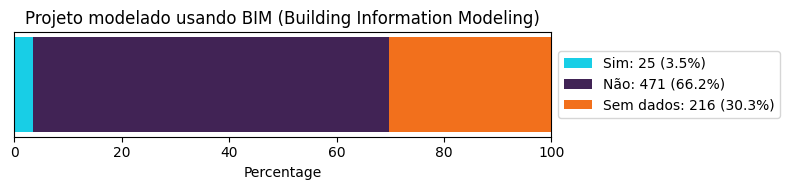

In [446]:
palette_bool = ["#18CEE6", "#412355", "#F2701C"]
# Convert and reorder
bim_map = {True: "Sim", False: "Não"}
bim_counts = (
    df["isModeladaPorBim"].map(bim_map).fillna("Sem dados").value_counts(dropna=False)
)

# Specify custom order
desired_order = ["Sim", "Não", "Sem dados"]
bim_counts = bim_counts.reindex(desired_order)
percentages = bim_counts / bim_counts.sum() * 100

# Create stacked bar
fig, ax = plt.subplots(figsize=(8, 2))
left = 0
colors = [palette_bool[i] for i in range(len(bim_counts))]
for i, (label, pct) in enumerate(zip(bim_counts.index, percentages)):
    ax.barh(
        0,
        pct,
        left=left,
        color=colors[i],
        label=f"{label}: {bim_counts.iloc[i]} ({pct:.1f}%)",
    )
    left += pct

ax.set_xlim(0, 100)
ax.set_yticks([])
ax.set_xlabel("Percentage")
ax.set_title("Projeto modelado usando BIM (Building Information Modeling)")
ax.legend(loc="center left", bbox_to_anchor=(1, 0.5))
plt.tight_layout()
plt.show()

Apenas 3.5% dos projetos usou BIM, enquanto 66.2% não usou.


In [447]:
def make_barh_plot(df: pd.DataFrame, column: str, title: str, color: str, extra_space: int = 1.15):
    plt.figure(figsize=(10, 6))
    
    # Get counts and percentages
    value_counts = df[column].value_counts(dropna=False)
    percentages = (value_counts / len(df)) * 100
    
    # Create DataFrame with both counts and percentages
    value_counts_df = pd.DataFrame({
        'count': value_counts,
        column: value_counts.index,
        'percentage': percentages
    }).reset_index(drop=True)
    
    ax = sns.barplot(
        data=value_counts_df,
        x="count", 
        y=column,
        hue=column,
        orient="h",
        order=value_counts_df[column],
        palette=[color for _ in range(len(value_counts_df))],
        legend=False,
    )

    # Add labels with both count and percentage
    for i, v in enumerate(value_counts_df['count']):
        ax.text(
            v + 5, # padding
            i,
            f'{int(v)} ({percentages[i]:.1f}%)',
            va='center'
        )

    # Extend x-axis to accommodate labels
    max_val = value_counts_df['count'].max()
    ax.set_xlim(0, max_val * extra_space)

    plt.title(title)
    plt.xlabel("Quantidade")
    plt.ylabel("")
    plt.tight_layout()
    plt.show()

/tmp/ipykernel_241338/312538705.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  f'{int(v)} ({percentages[i]:.1f}%)',


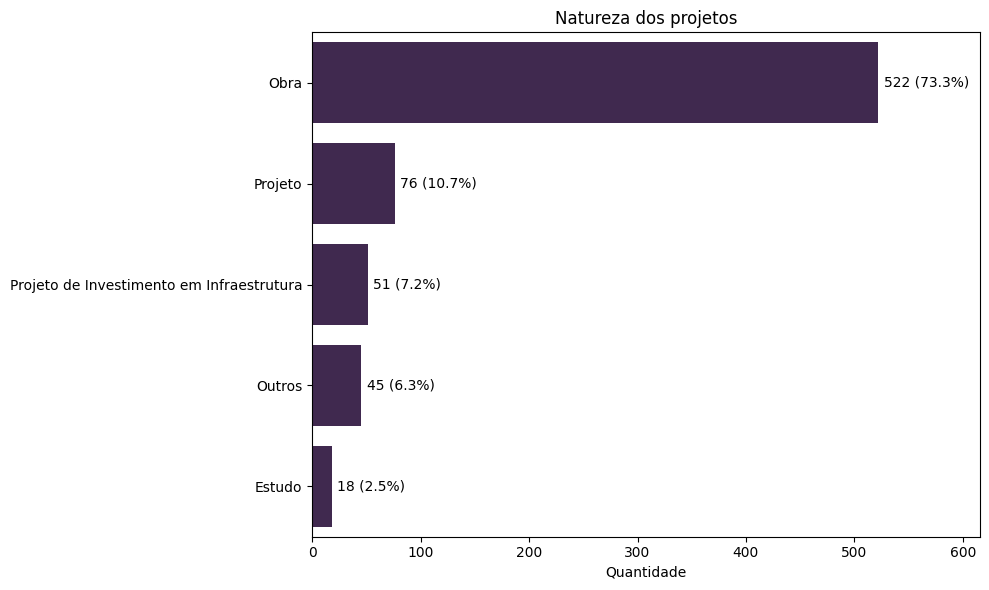

In [448]:
make_barh_plot(df, "natureza", "Natureza dos projetos", palette[0], extra_space=1.18)

**Natureza dos projetos**: A grande maioria dos itens (73%) é classificado como obra, e não como projeto ou projeto de investimento em infraestrutura.


/tmp/ipykernel_241338/312538705.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  f'{int(v)} ({percentages[i]:.1f}%)',


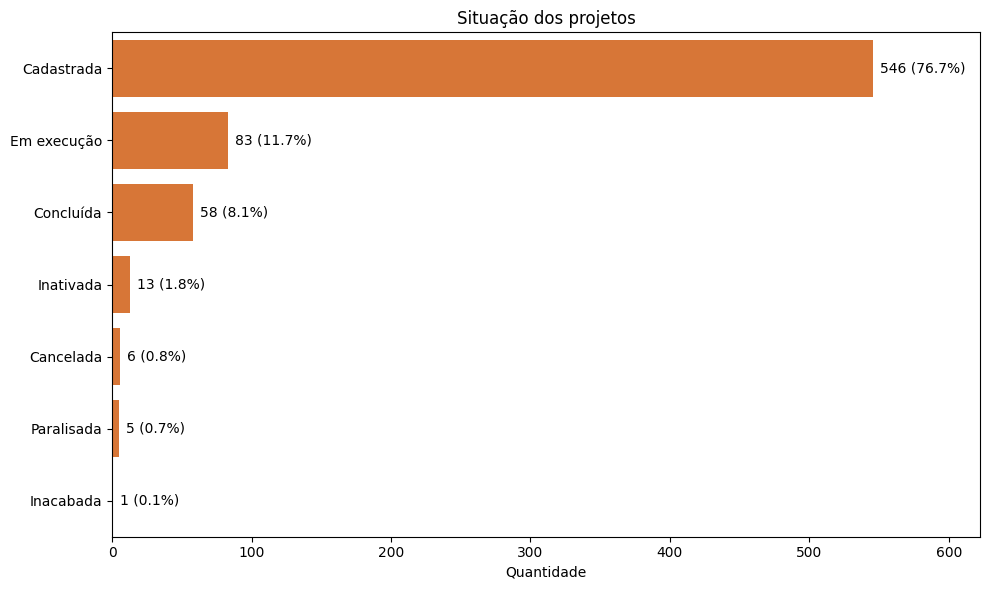

In [449]:
make_barh_plot(df, "situacao", "Situação dos projetos", palette[1], extra_space=1.14)

**Situação dos projetos**: 76% projetos estão cadastrados, com 11% em execução, 8% concluídos e 3% inativados, cancelados, paralisados ou inacabados.

/tmp/ipykernel_241338/312538705.py:15: UserWarning: The palette list has more values (7) than needed (6), which may not be intended.
  ax = sns.barplot(
/tmp/ipykernel_241338/312538705.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  f'{int(v)} ({percentages[i]:.1f}%)',


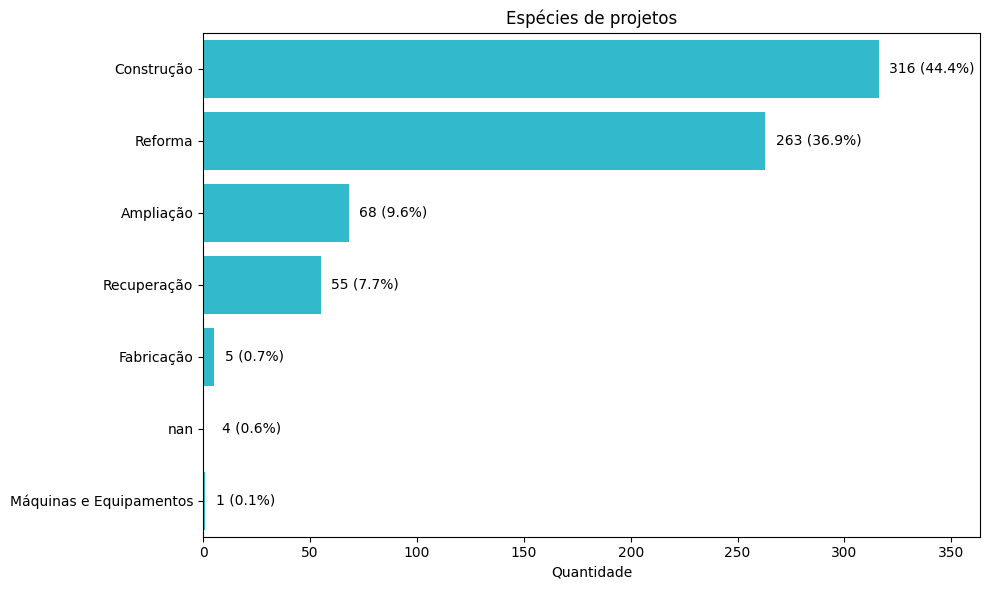

In [450]:
make_barh_plot(df, "especie", "Espécies de projetos", palette[2])

**Espécies de projetos**: 44% construção de novos projetos e 54% reforma, ampliação ou recuperação de projetos existentes.

---

Resumo das variáveis categóricas:

- **BIM**: Apenas 3.5% dos projetos usou BIM, enquanto 66.2% não usou.
- **Natureza dos projetos**: A grande maioria dos itens (73%) é classificado como obra, e não como projeto ou projeto de investimento em infraestrutura.
- **Situação dos projetos**: 76% projetos estão cadastrados, com 11% em execução, 8% concluídos e 3% inativados, cancelados, paralisados ou inacabados.
- **Espécies de projetos**: 44% construção de novos projetos e 54% reforma, ampliação ou recuperação de projetos existentes.

In [451]:
`qdtEmpregosGerados`
`populacaoBeneficiada`

SyntaxError: invalid syntax (3613391478.py, line 1)

In [ ]:
# todo
## bertopic
# check map
# check dates compared to today

## Insights


vários campos tem problema sistemáticos:

-   with `descPopulacaoBeneficiada` being template text
-   `qdtEmpregosGerados` as empty string (ver, por exemplo, `df[(df["qdtEmpregosGerados"] == ' ') & (df['descPopulacaoBeneficiada'] == 'Descrição população beneficiada')]`)
-   `descPlanoNacionalPoliticaVinculado`: alguns usuários tratam como valor categórico e outros como texto,
-   CEP vazio ou `1`

Talvez o formulário seja confuso, talvez falte masking, talvez o campo não se aplique a um projeto. Isso precisaria ser investigado melhor.


## Conclusão
